In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A
import torch
import pandas as pd
import numpy as np
torch.cuda.set_device(1)

In [5]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_train.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        output_path_csv.write("images, class\n")

#         output_path_csv.write(head)

    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l)
#                     print(l)

In [6]:
create_csvValid("./dataset38_Marco/train")

In [7]:
dfValid = pd.read_csv('./dataset38_Marco/df_train.csv')
dfTest = pd.read_csv('./dataset38_Marco/df_test.csv')

prueba = dfValid
prueba = prueba.iloc[np.random.permutation(len(prueba))]
prueba = prueba[0:int(len(prueba)*0.1)]
# In[6]:
# Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]

# Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# 0.1 posiciones si está se devuelve 
def is_valid(path):
    name = path[0]
#     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
    return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# In[13]:

def get_class(path):
    name = path[0]
    return (dfValid[dfValid['images']==name])['class']


In [8]:
dfValid.loc[:,'images']=dfValid['images'].apply(lambda x: "./dataset38_Marco/train/"+x)

In [9]:
dfTest.loc[:,'images']=dfTest['images'].apply(lambda x: "./dataset38_Marco/test/"+x)

In [10]:
dfValid['split'] = False
dfTest['split'] = True

In [11]:
dfTotal = pd.concat([dfValid,dfTest])

In [12]:
dfTotal.to_csv('df_total.csv')

In [13]:
def get_dls(presize=512,size=384,M=0,bs=16):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             splitter=ColSplitter(2),
             get_x = ColReader(0,suff='.jpg'),
             get_y=ColReader(1),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfTotal,bs=bs)
    return dls

In [14]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrs50_38FRAMES',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [15]:
dlsTrain = get_dls()

learn = Learner(dlsTrain,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')], cbs = callbacks,
                loss_func= CrossEntropyLossFlat()).to_fp16()

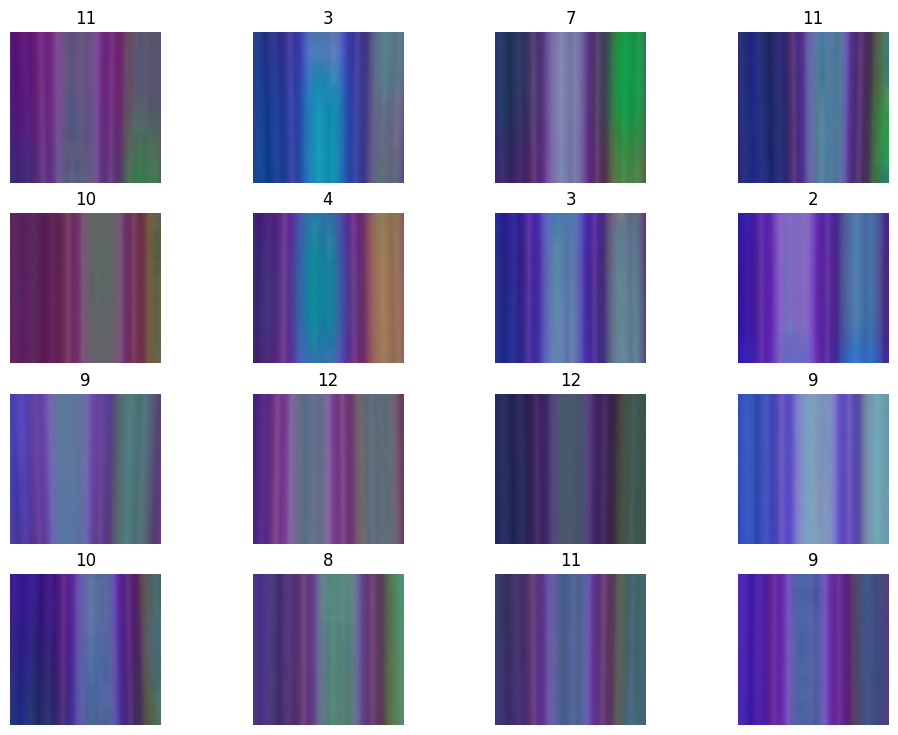

In [16]:
dlsTrain.show_batch(max_n=100, figsize=(12,9))

SuggestedLRs(valley=0.00013182566908653826)

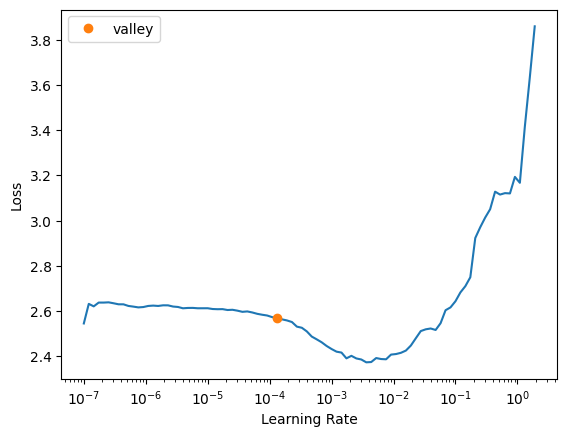

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.992037,1.070047,0.621538,0.775561,04:23


Better model found at epoch 0 with cohen_kappa_score value: 0.7755608372708436.


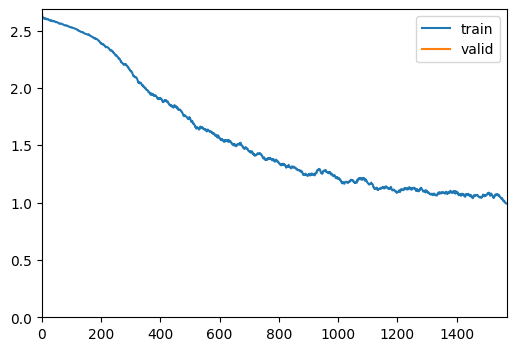

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.795579,0.973744,0.655967,0.811852,04:29
1,0.717176,0.964808,0.669816,0.817748,04:35
2,0.668871,0.934698,0.684183,0.824280,04:41
3,0.580371,0.966536,0.678488,0.825402,04:42
4,0.594180,0.976211,0.677194,0.820751,04:46
5,0.533343,0.933615,0.692208,0.833027,04:41
6,0.500338,0.963094,0.682371,0.822204,04:38
7,0.510965,0.994967,0.678877,0.813748,04:39
8,0.486688,1.007358,0.686254,0.821900,04:39
9,0.435304,1.030098,0.681595,0.824717,04:43


Better model found at epoch 0 with cohen_kappa_score value: 0.811852303963243.


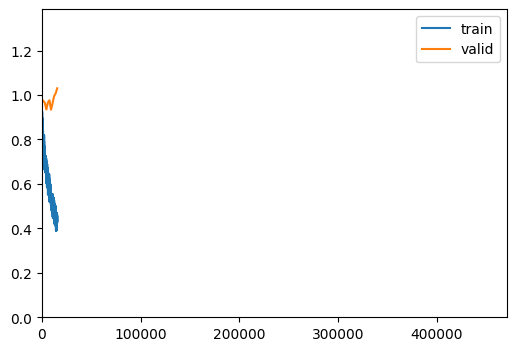

Better model found at epoch 1 with cohen_kappa_score value: 0.8177477052345776.
Better model found at epoch 2 with cohen_kappa_score value: 0.824280415445501.
Better model found at epoch 3 with cohen_kappa_score value: 0.8254017512206491.
Better model found at epoch 5 with cohen_kappa_score value: 0.8330268573023442.
No improvement since epoch 5: early stopping


In [18]:
learn.fine_tune(300,base_lr=1e-4)

In [23]:
learn.load('resnetrs50_38FRAMES')

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTotal,bs=4)

In [25]:
learn.dls = dlsTest

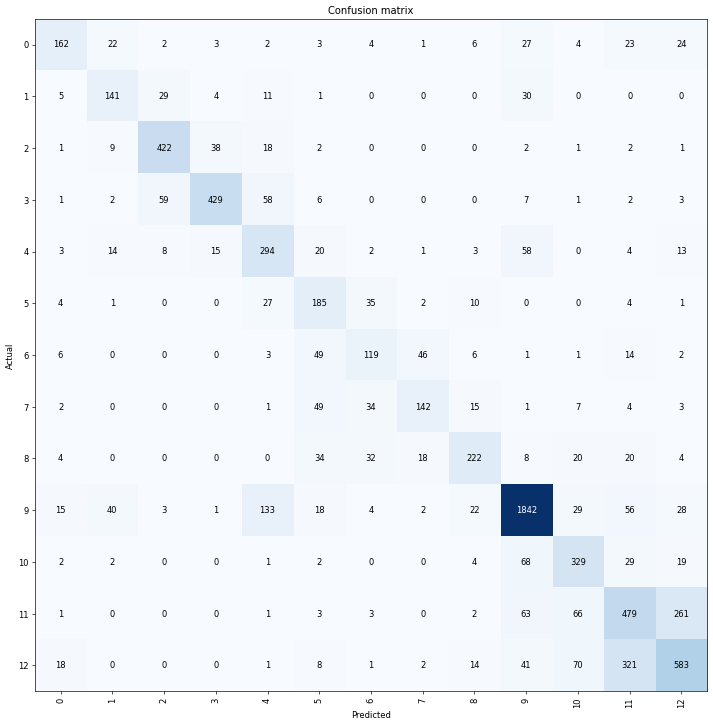

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [27]:
learn.validate()

IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

In [28]:
learn.export(fname='resnetrs50_38FRAMES.pkl')

In [37]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, confusion_matrix

preds,gt = learn.get_preds()

In [38]:
gt

tensor([ 0,  1,  1,  ..., 12, 12,  0])

In [31]:
preds=np.argmax(preds,axis=1)

Esto esta hecho para poder usar los métodos que me han pasado y así poder usar las métrcias y compararlos

In [33]:
with open('./prueba_resultados/resultados_Resnet50d_preds_38FRAMES.txt', 'w') as f:
    f.write("### Frame level recognition: ###\n")
    for p in preds:
        f.write(np.array2string(p) + " ")


In [34]:
with open('./prueba_resultados/resultados_Resnet50d_gt_38FRAMES.txt', 'w') as f:
    for g in gt:
        f.write(np.array2string(g) + "\n")

In [39]:
f1_score(np.argmax(preds,axis=1),gt,average='macro')

0.6503048509318143

In [40]:
accuracy_score(np.argmax(preds,axis=1),gt)

0.6923375614807145

In [ ]:
with open('resultados_Resnet50_38FRAMES.txt', 'w') as f:
    f.write('El accuracy obtenido en test es:\n')
    f.write(accuracy_score(np.argmax(preds,axis=1),gt))
    f.write('El F1-score que tenemos en test es:\n')
    f.write(f1_score(np.argmax(preds,axis=1),gt,average='macro'))

# Estas son las métricas que usa Marco

In [16]:
conf_mat = confusion_matrix(gt,np.argmax(preds,axis=1))

In [19]:
from math import isnan

def get_f1_score(conf_mat, show=True):
    n_classes = len(conf_mat)
    control = 13- n_classes
    text = 'F1 score for each classes: \n'
    # total_samples = conf_mat.sum().sum()
    f1_tot = 0
    for label in range(n_classes):
        tp = conf_mat[label,label]
        fn = 0
        tn = 0
        fp = 0
        for a in range(n_classes):
            for b in range(n_classes):
                if a == label and not b == label: fn += conf_mat[a,b]
                if not a == label and not b == label: tn += conf_mat[a,b]
                if not a == label and b == label: fp += conf_mat[a,b]
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        f1 = 2 * precision * recall / (recall + precision)
        f1_tot = f1_tot + f1 if not isnan(f1) else f1_tot
        text = text + 'Class {} f1 score = {} \n'.format(label, f1)
    
    text = text + '---------------------------\n' + 'Average f1 score = {} \n'.format(f1_tot/n_classes)
    if show: print(text)
    return text, f1


def get_balanced_score(conf_mat, show=True):
    n_classes = len(conf_mat)
    control = 13 - n_classes
    text = 'Balanced score for each classes: \n'
    total_samples = conf_mat.sum().sum()
    b_acc_tot = 0
    for label in range(n_classes):
        tp = conf_mat[label,label]
        fn = 0
        tn = 0
        fp = 0

        for a in range(n_classes):
            for b in range(n_classes):
                if a == label and not b == label: fn += conf_mat[a,b]
                if not a == label and not b == label: tn += conf_mat[a,b]
                if not a == label and b == label: fp += conf_mat[a,b]
        term_1 = tp/(tp+fn)
        term_2 = tn/(tn+fp)
        b_acc = (term_1 + term_2)/2
        b_acc_tot = b_acc_tot + b_acc if not isnan(b_acc) else b_acc_tot
        text = text + 'Class {} accuracy = {} \n'.format(label, b_acc)

    avg_acc = conf_mat.diagonal().sum()/total_samples
    text = text + '---------------------------\n' + 'Average balanced accuracy = {} \n'.format(b_acc_tot/n_classes)
    text = text + 'Average accuracy = {} \n'.format(avg_acc)
    if show : print(text)
    return text, avg_acc, b_acc_tot/n_classes


In [20]:
get_balanced_score(conf_mat)

Balanced score for each classes: 
Class 0 accuracy = 0.8311587479721771 
Class 1 accuracy = 0.7729898006286682 
Class 2 accuracy = 0.9488325436462202 
Class 3 accuracy = 0.899917690022517 
Class 4 accuracy = 0.8662965641952984 
Class 5 accuracy = 0.8266908212560387 
Class 6 accuracy = 0.8579988851727982 
Class 7 accuracy = 0.7795691360551178 
Class 8 accuracy = 0.8781987803513484 
Class 9 accuracy = 0.9372791841194683 
Class 10 accuracy = 0.7475219214639726 
Class 11 accuracy = 0.8101882766507786 
Class 12 accuracy = 0.8678938790947511 
---------------------------
Average balanced accuracy = 0.8480412485099351 
Average accuracy = 0.7797340998922027 



('Balanced score for each classes: \nClass 0 accuracy = 0.8311587479721771 \nClass 1 accuracy = 0.7729898006286682 \nClass 2 accuracy = 0.9488325436462202 \nClass 3 accuracy = 0.899917690022517 \nClass 4 accuracy = 0.8662965641952984 \nClass 5 accuracy = 0.8266908212560387 \nClass 6 accuracy = 0.8579988851727982 \nClass 7 accuracy = 0.7795691360551178 \nClass 8 accuracy = 0.8781987803513484 \nClass 9 accuracy = 0.9372791841194683 \nClass 10 accuracy = 0.7475219214639726 \nClass 11 accuracy = 0.8101882766507786 \nClass 12 accuracy = 0.8678938790947511 \n---------------------------\nAverage balanced accuracy = 0.8480412485099351 \nAverage accuracy = 0.7797340998922027 \n',
 0.7797340998922027,
 0.8480412485099351)

In [21]:
get_f1_score(conf_mat)

F1 score for each classes: 
Class 0 f1 score = 0.7428571428571429 
Class 1 f1 score = 0.6115702479338844 
Class 2 f1 score = 0.8654353562005277 
Class 3 f1 score = 0.8616187989556137 
Class 4 f1 score = 0.7190332326283989 
Class 5 f1 score = 0.6815642458100558 
Class 6 f1 score = 0.6979166666666667 
Class 7 f1 score = 0.6666666666666665 
Class 8 f1 score = 0.7536231884057971 
Class 9 f1 score = 0.8911138923654568 
Class 10 f1 score = 0.6324110671936758 
Class 11 f1 score = 0.6720257234726689 
Class 12 f1 score = 0.7428571428571429 
---------------------------
Average f1 score = 0.7337456440010536 



('F1 score for each classes: \nClass 0 f1 score = 0.7428571428571429 \nClass 1 f1 score = 0.6115702479338844 \nClass 2 f1 score = 0.8654353562005277 \nClass 3 f1 score = 0.8616187989556137 \nClass 4 f1 score = 0.7190332326283989 \nClass 5 f1 score = 0.6815642458100558 \nClass 6 f1 score = 0.6979166666666667 \nClass 7 f1 score = 0.6666666666666665 \nClass 8 f1 score = 0.7536231884057971 \nClass 9 f1 score = 0.8911138923654568 \nClass 10 f1 score = 0.6324110671936758 \nClass 11 f1 score = 0.6720257234726689 \nClass 12 f1 score = 0.7428571428571429 \n---------------------------\nAverage f1 score = 0.7337456440010536 \n',
 0.7428571428571429)

# Estas son las pruebas para la predicción del vídeo 002 del usuario 027

In [117]:
dfTest_027 = pd.read_csv('./dataset_Usr027Video002/test/IDU027V002_20220209_163603/IDU027V002_annotation_images.csv')

In [118]:
dfTest_027.loc[:,'images']=dfTest_027['images'].apply(lambda x: "./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/"+x)

In [119]:
dfTest_027['split'] = True

In [120]:
dfTotal = pd.concat([dfValid,dfTest_027])

In [121]:
dfTest_027

,images,class,split
0,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_0_to_77,0,True
1,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1_to_78,0,True
2,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_2_to_79,0,True
3,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_3_to_80,0,True
4,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_4_to_81,0,True
...,...,...,...
1986,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1986_to_2063,12,True
1987,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1987_to_2064,12,True
1988,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1988_to_2065,12,True
1989,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1989_to_2066,12,True


In [122]:
dfTotal

,images,class,split
0,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_0_to_77,1,False
1,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_57_to_134,1,False
2,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_114_to_191,1,False
3,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_171_to_248,2,False
4,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_228_to_305,2,False
...,...,...,...
1986,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1986_to_2063,12,True
1987,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1987_to_2064,12,True
1988,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1988_to_2065,12,True
1989,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1989_to_2066,12,True


In [124]:
dbTest_027 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dbTest_027 = dbTest_027.dataloaders(dfTotal,bs=4)

In [125]:
learn.dls = dbTest_027

## Este es para probarlo con el vídeo pero con la estructura igual que el resto del dataset

In [127]:
path_vid = './dataset38_Marco/test/IDU027V002_20220209_163603'
imgs = []
probs = []
classes_pred = []
for _, line in dfTest.iterrows():
#     print(line[0])
    if "IDU027V002_20220209_163603" in line[0]:
        imgs.append(line[0])

for img in imgs:
    img = img + '.jpg'
    predic_class,_,probs1 = learn.predict(img)
    frame = [0]*13
        
    frame[int(predic_class)]+=1
    print(img)
    print(predic_class)
    print(frame)
    # classes_pred.append(frame)
    # probs.append(probs1)

./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_0_to_77.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_57_to_134.jpg
2
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_114_to_191.jpg
2
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_171_to_248.jpg
2
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_228_to_305.jpg
3
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_285_to_362.jpg
3
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_342_to_419.jpg
4
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_399_to_476.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_456_to_533.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_513_to_590.jpg
5
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_570_to_647.jpg
6
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_627_to_704.jpg
7
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_684_to_761.jpg
8
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_741_to_818.jpg
8
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_798_to_875.jpg
8
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_855_to_932.jpg
11
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_912_to_989.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_969_to_1046.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1026_to_1103.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1083_to_1160.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1140_to_1217.jpg
10
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1197_to_1274.jpg
10
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1254_to_1331.jpg
11
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1311_to_1388.jpg
11
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1368_to_1445.jpg
10
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1425_to_1502.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1482_to_1559.jpg
11
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1539_to_1616.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1596_to_1673.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1653_to_1730.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1710_to_1787.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1767_to_1844.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1824_to_1901.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1881_to_1958.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1938_to_2015.jpg
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


./dataset77_Marco/test/IDU027V002_20220209_163603/images/IDU027V002_from_1995_to_2072.jpg
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


## Este es para probarlo con el vídeo pero las imágenes están generadas frame a frame para acercarse más a una situación real

In [151]:
path_vid = './dataset_Usr027Video002/test/IDU027V002_20220209_163603'
imgs = []
probs = []
classes_pred = []


for _, line in dfTest_027.iterrows():
    # print(line[0])
    if "IDU027V002_20220209_163603" in line[0]:
        imgs.append(line[0])

for img in imgs:
    img = img + '.jpg'
    predic_class,_,probs1 = learn.predict(img)
    frame = [0]*13
        
    frame[int(predic_class)]+=1
    # print(img)
    # print(predic_class)
    # print(frame)
    classes_pred.append(frame)
    probs.append(probs1)

In [153]:
len(classes_pred)

1991

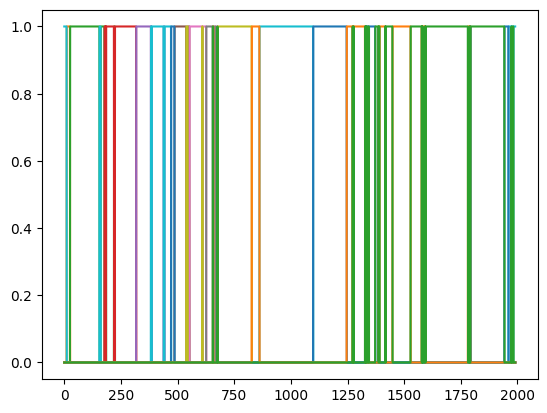

In [154]:
from matplotlib.pyplot import plot
plot(range(0,len(classes_pred)),[x for x in classes_pred])

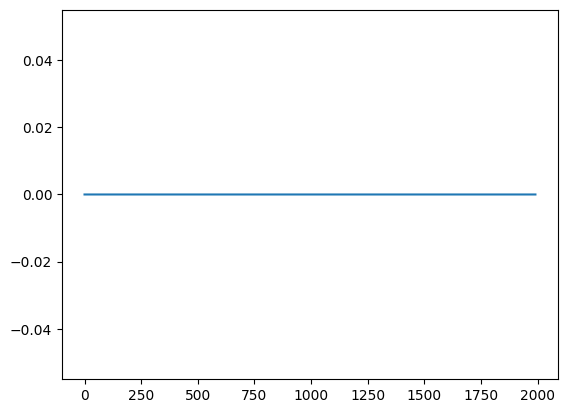

In [155]:
plot(range(0,len(classes_pred)),[x[0] for x in classes_pred])

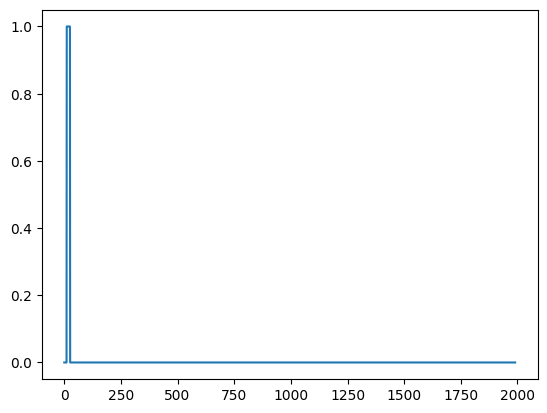

In [156]:
plot(range(0,len(classes_pred)),[x[1] for x in classes_pred])

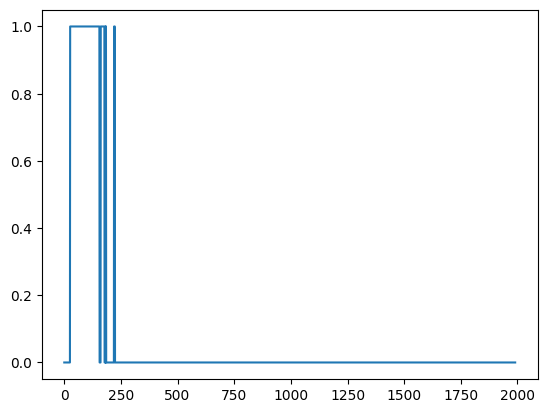

In [157]:
plot(range(0,len(classes_pred)),[x[2] for x in classes_pred])

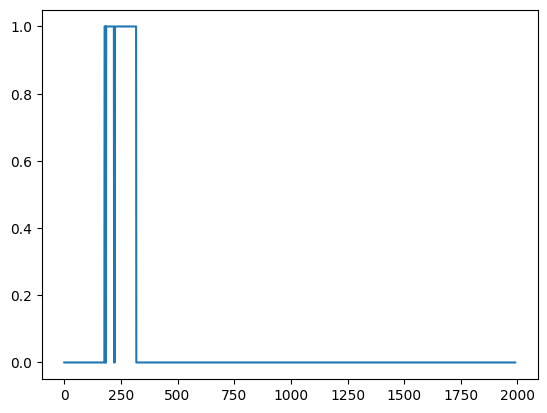

In [158]:
plot(range(0,len(classes_pred)),[x[3] for x in classes_pred])

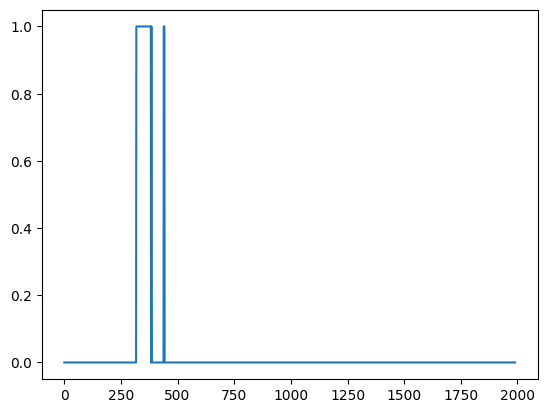

In [159]:
plot(range(0,len(classes_pred)),[x[4] for x in classes_pred])

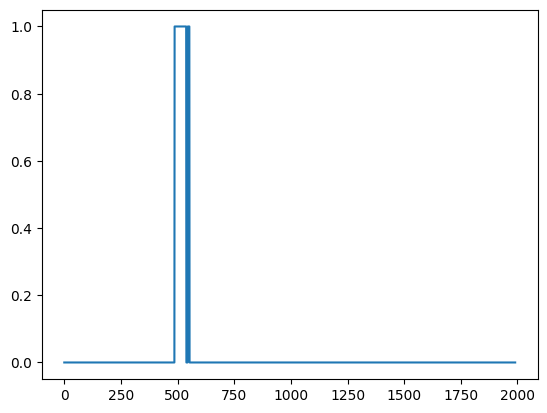

In [160]:
plot(range(0,len(classes_pred)),[x[5] for x in classes_pred])

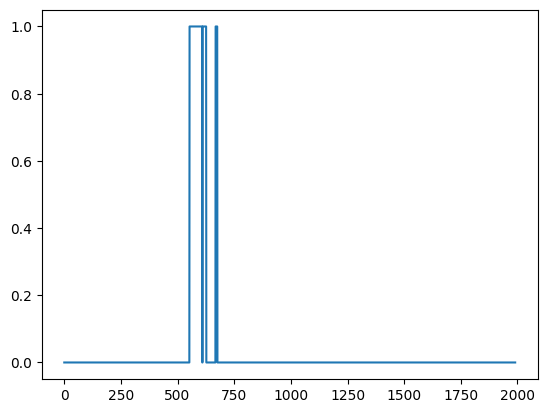

In [161]:
plot(range(0,len(classes_pred)),[x[6] for x in classes_pred])

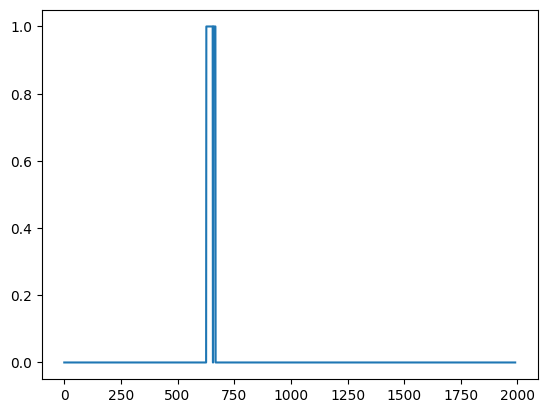

In [162]:
plot(range(0,len(classes_pred)),[x[7] for x in classes_pred])

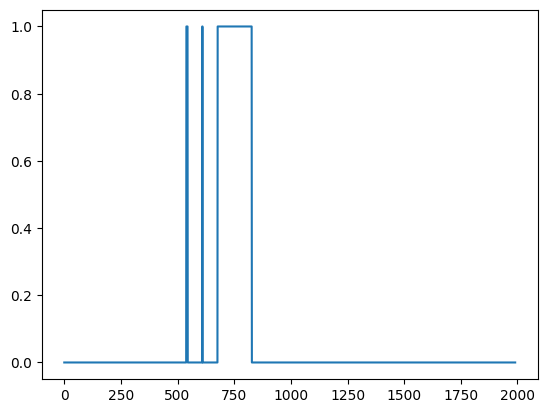

In [163]:
plot(range(0,len(classes_pred)),[x[8] for x in classes_pred])

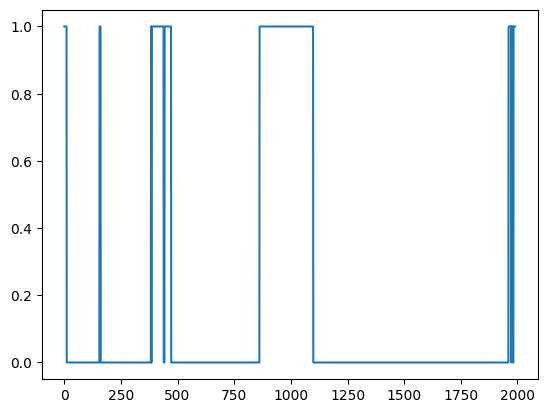

In [164]:
plot(range(0,len(classes_pred)),[x[9] for x in classes_pred])

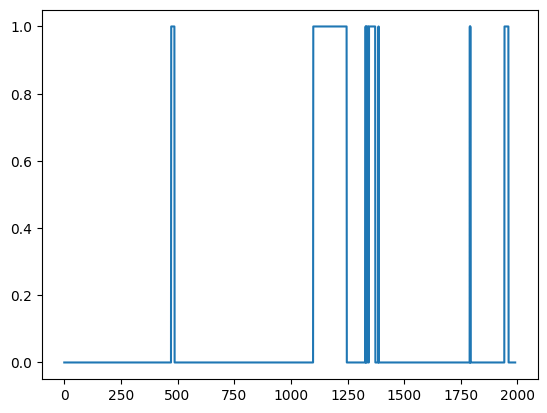

In [165]:
plot(range(0,len(classes_pred)),[x[10] for x in classes_pred])

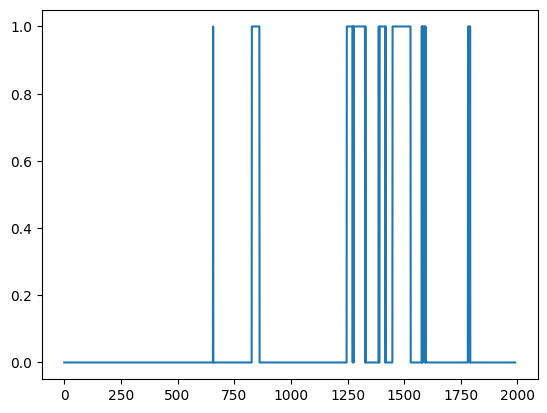

In [166]:
plot(range(0,len(classes_pred)),[x[11] for x in classes_pred])

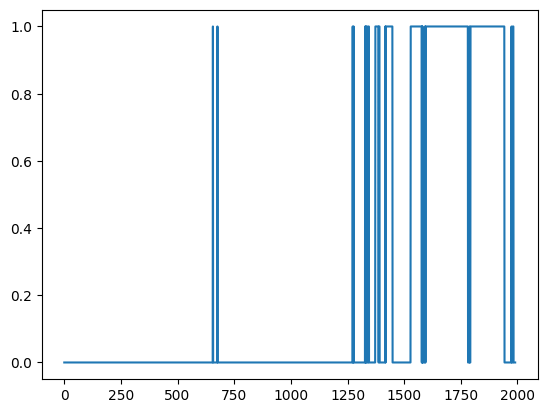

In [167]:
plot(range(0,len(classes_pred)),[x[12] for x in classes_pred])